# Nettoyage du texte

## Importation des librairies

In [1]:
import pandas as pd
import nltk
import string
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
from sklearn import preprocessing
from seaborn import countplot

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinelv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/justinelv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/justinelv/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/justinelv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Chargement des données 

In [3]:
pd.options.display.max_rows = 1050
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 50

df = pd.read_csv('./csv/cleaned.csv')

In [4]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,...,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",...,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",...,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",...,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

## Sélection des colonnes utiles

In [6]:
df_process = df[['uniq_id','product_name','description','product_category_tree']].copy()
df_process.head(1)

,uniq_id,product_name,description,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."


## Nettoyage des données textes

### Fonction pour nettoyer les données 

In [7]:
# pour enlever la ponctuation
ponctuations = string.punctuation + '�' + '°' + '…' + '±' + '•' + '’' + '–' + '“' + '”' 
# stopwords, ce sont les mots qui apparaissent très fréquemment mais qui n’apporte pas de sens à la phrase (comme « de », « le », « une »)
stopwords = nltk.corpus.stopwords.words('english')
stopwords_custom = stopwords
stopwords_custom.append('yes')
# mots (words) qui proviennent d’un dictionnaire anglais (directement intégré à la librairie nltk)
words = set(nltk.corpus.words.words())
# un lemmatizer, cette objet nous permet de préserver la racine des mots de tel sorte que deux mots ayant une même souche seront considérés comme un seul et même mot 
lemmatizer = WordNetLemmatizer()

In [8]:
def text_preprocessing(df_column, words_filter=True):
    
    preprocess_list = []
    
    for sentence in df_column :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in ponctuations])

        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords_custom]

        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        
        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha()) if words_filter else ' '.join(w for w in words_lemmatize) 
        
        remove_one_two_letters_word = re.sub(r'\b[a-zA-Z]{1,2}(?=\s|$)','',sentence_clean)
        
        preprocess_list.append(remove_one_two_letters_word)
        
    return preprocess_list 

Le product name est nettoyé avec une fonction légèrement différente, les mots ne doivent pas faire partie de la liste words car certains mots n'y sont pas et cela créé des lignes vides.

### Nettoyage de la colonne description

In [9]:
description_clean = text_preprocessing(df_process['description'])

In [10]:
df_process['description_clean'] = description_clean
df_process['description_clean'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price  curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model  duster color multicolor dimension length box number content sale package pack sale package curtain body design material polyester'

### Nettoyage de la colonne product_name

In [11]:
product_name_clean = text_preprocessing(df_process['product_name'], words_filter=False )

In [12]:
df_process['product_name_clean'] = product_name_clean
df_process['product_name_clean'][0]

'elegance polyester multicolor abstract eyelet door curtain'

In [13]:
df_process

,uniq_id,product_name,description,product_category_tree,description_clean,product_name_clean
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification cotton bath towel bath towel red...,sathiyas cotton bath towel
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature cotton terry face towel set size s...,eurospa cotton terry face towel set
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature royal fashion cotton printed king ...,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature print cotton floral king sized dou...,jaipur print cotton floral king sized double b...
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",time watch boy buy time watch boy great di...,maserati time analog watch boy
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...","Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",elegance watch men boy buy elegance watch men ...,camerii elegance analog watch men boy
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",star watch boy price whether way work abroad ...,star ufttswbkbr analog watch boy
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, Boys","Alfajr WY16B Youth Digital Watch - For Men, B...","[""Watches >> Wrist Watches >> Alfajr Wrist Wat...",youth digital watch men boy buy youth digital ...,alfajr wyb youth digital watch men boy
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",tag formula watch boy men buy tag formula watc...,tag heuer cauba formula analog watch boy men


### Création des labels

Pour extraire les catégories du la colonne 'product_category_tree', j'ai testé de prendre la première catégorie et la sous catégorie pour voir si il y en avait une mieux que l'autre pour réprésenter nos groupes de produits.

In [31]:
def create_categories(index:int, new_column_name:str):
    extract_category = lambda x: x.split(">>")[index].strip().strip(']["')
    df_process[new_column_name] = df_process['product_category_tree'].apply(extract_category)
    print(f'Exemple de classe: {df_process[new_column_name][0]}, nombre de classe : {df_process[new_column_name].nunique()}')
    countplot(x=new_column_name,data=df_process).set_title("Data Distribution")

Exemple de classe: Home Furnishing, nombre de classe : 7


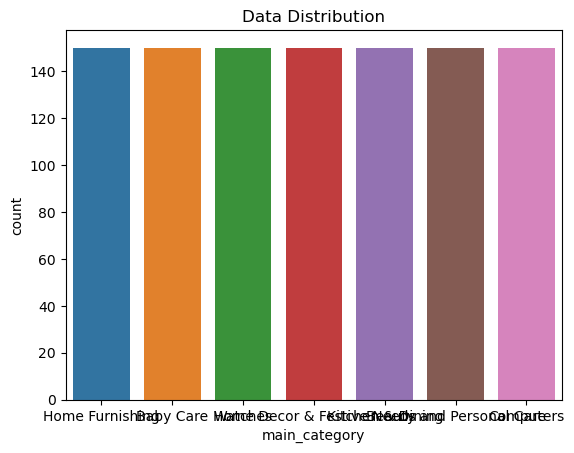

In [32]:
create_categories(0, 'main_category')

Exemple de classe: Curtains & Accessories, nombre de classe : 62


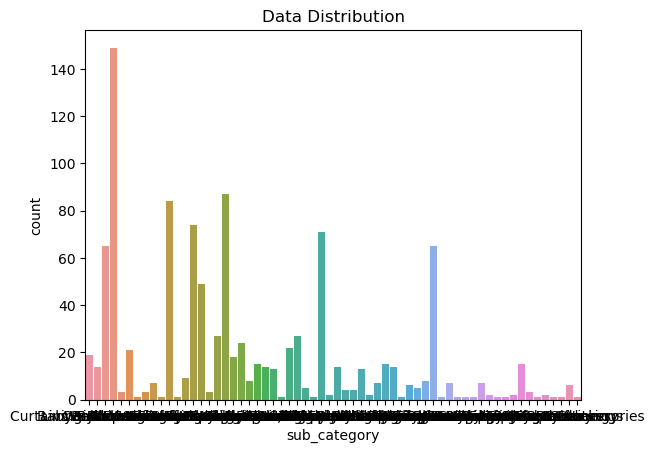

In [33]:
create_categories(1, 'sub_category')

Les catégories représentées dans la colonne main_category sont mieux réparties que les catégories de la colonne sub_category. La colonne main_category sera donc choisit pour être le label.

In [17]:
label_encoder = preprocessing.LabelEncoder()
label_encoder .fit(df_process['main_category'])
df_process['main_category_num']=label_encoder.transform(df_process['main_category'])
df_process

,uniq_id,product_name,description,product_category_tree,description_clean,product_name_clean,main_category,sub_category,main_category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,elegance polyester multicolor abstract eyelet ...,Home Furnishing,Curtains & Accessories,4
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification cotton bath towel bath towel red...,sathiyas cotton bath towel,Baby Care,Baby Bath & Skin,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature cotton terry face towel set size s...,eurospa cotton terry face towel set,Baby Care,Baby Bath & Skin,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature royal fashion cotton printed king ...,santosh royal fashion cotton printed king size...,Home Furnishing,Bed Linen,4
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature print cotton floral king sized dou...,jaipur print cotton floral king sized double b...,Home Furnishing,Bed Linen,4
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",time watch boy buy time watch boy great di...,maserati time analog watch boy,Watches,Wrist Watches,6
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...","Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",elegance watch men boy buy elegance watch men ...,camerii elegance analog watch men boy,Watches,Wrist Watches,6
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",star watch boy price whether way work abroad ...,star ufttswbkbr analog watch boy,Watches,Wrist Watches,6
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, Boys","Alfajr WY16B Youth Digital Watch - For Men, B...","[""Watches >> Wrist Watches >> Alfajr Wrist Wat...",youth digital watch men boy buy youth digital ...,alfajr wyb youth digital watch men boy,Watches,Wrist Watches,6
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",tag formula watch boy men buy tag formula watc...,tag heuer cauba formula analog watch boy men,Watches,Wrist Watches,6


Text(0.5, 1.0, 'Data Distribution')

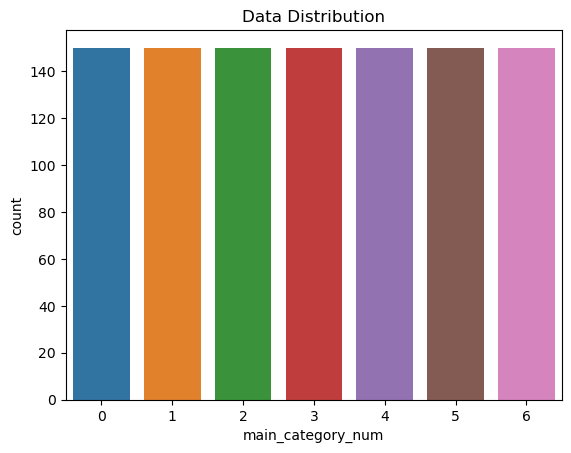

In [18]:
countplot(x='main_category_num',data=df_process).set_title("Data Distribution")

# Création du dataframe avec les données nettoyées

In [19]:
df_clean_text = df_process[['uniq_id','product_name_clean','description_clean','main_category','main_category_num' ]].copy()
df_clean_text

,uniq_id,product_name_clean,description_clean,main_category,main_category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,elegance polyester multicolor abstract eyelet ...,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,sathiyas cotton bath towel,specification cotton bath towel bath towel red...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,eurospa cotton terry face towel set,key feature cotton terry face towel set size s...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,santosh royal fashion cotton printed king size...,key feature royal fashion cotton printed king ...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,jaipur print cotton floral king sized double b...,key feature print cotton floral king sized dou...,Home Furnishing,4
5,893aa5ed55f7cff2eccea7758d7a86bd,maserati time analog watch boy,time watch boy buy time watch boy great di...,Watches,6
6,f355cc1ccb08bd0d283ed979b7ee7515,camerii elegance analog watch men boy,elegance watch men boy buy elegance watch men ...,Watches,6
7,dd0e3470a7e6ed76fd69c2da27721041,star ufttswbkbr analog watch boy,star watch boy price whether way work abroad ...,Watches,6
8,41384da51732c0b4df3de8f395714fbb,alfajr wyb youth digital watch men boy,youth digital watch men boy buy youth digital ...,Watches,6
9,710ed5f2393a4b9e8823aa0029f71f93,tag heuer cauba formula analog watch boy men,tag formula watch boy men buy tag formula watc...,Watches,6


In [20]:
# J'ajoute une colonne qui ajoute description_clean et product_name_clean pour obtenir plus d'infos en une colonne
df_clean_text['description_name'] = df_clean_text.description_clean + df_clean_text.product_name_clean
df_clean_text.description_name[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral polyester multicolor abstract eyelet door curtain height pack price  curtain look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model  duster color multicolor dimension length box number content sale package pack sale package curtain body design material polyesterelegance polyester multicolor abstract eye

In [21]:
df_clean_text.to_csv('./csv/test_clean.csv')